In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install cityscapesscripts

In [ ]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, Concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import files
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K

In [ ]:
from cityscapesscripts.download import downloader
session = downloader.login()
downloader.get_available_packages(session=session)
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path='/content/drive/MyDrive/Cityscapes')

Cityscapes username or email address: rahulgg
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y


Download progress: 100%|█████████▉| 241M/241M [00:09<00:00, 25.7MB/s]


Download progress:  98%|█████████▊| 10.8G/11.0G [07:09<00:08, 27.0MB/s]


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import os
base_dir='content/data'
folder1 = os.path.join(base_dir, 'gtFine')
folder2 = os.path.join(base_dir, 'leftImg8bit')

# Create the base directory and the two subdirectories
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)


In [ ]:
!unzip '/content/drive/MyDrive/Cityscapes/gtFine_trainvaltest.zip' -d /content/content/data/gtFine

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000117_000019_gtFine_color.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000114_000019_gtFine_color.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000434_000019_gtFine_labelIds.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000420_000019_gtFine_color.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000483_000019_gtFine_instanceIds.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000420_000019_gtFine_instanceIds.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000254_000019_gtFine_color.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000490_000019_gtFine_color.png  
  inflating: /content/content/data/gtFine/gtFine/test/berlin/berlin_000448_000019_gtFine_polygons.json  
  inflating: /content

In [ ]:
!unzip '/content/drive/MyDrive/Cityscapes/leftImg8bit_trainvaltest.zip' -d /content/content/data/leftImg8bit

Streaming output truncated to the last 5000 lines.
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: /content/content/data/leftImg8bit/leftImg8bit/train/jena/jena_000089_000019_left

In [ ]:
# Directory setup
from tensorflow.keras.preprocessing.image import load_img, img_to_array
data_dir = "/content/content/data"
images_dir = os.path.join(data_dir, "leftImg8bit/leftImg8bit")
masks_dir = os.path.join(data_dir, "gtFine/gtFine")

In [ ]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light',
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
               'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)

colors = [
    [0, 0, 0], [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153], [153, 153, 153],
    [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152], [0, 130, 180], [220, 20, 60], [255, 0, 0],
    [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32],
]

label_colours = dict(zip(range(n_classes), colors))

In [ ]:
# Function to encode segmentation masks
def encode_segmap(mask):
    mask = np.array(mask, dtype=np.int32)
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

# Function to decode segmentation masks
def decode_segmap(temp):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r
    rgb[:, :, 1] = g
    rgb[:, :, 2] = b
    return rgb

In [ ]:
# Function to recursively gather all image and mask paths
def get_image_paths(images_dir, masks_dir, subset):
    image_files = []
    mask_files = []

    for root, _, files in os.walk(os.path.join(images_dir, subset)):
        for file in files:
            if file.endswith('_leftImg8bit.png'):
                image_files.append(os.path.join(root, file))

    for root, _, files in os.walk(os.path.join(masks_dir, subset)):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_files.append(os.path.join(root, file))

    return sorted(image_files), sorted(mask_files)

# Create a dataset for a specific subset
def create_subset_dataset(images_dir, masks_dir, subset, batch_size=8):
    image_paths, mask_paths = get_image_paths(images_dir, masks_dir, subset)

    # Debugging: Print the number of images and masks found
    print(f"Found {len(image_paths)} {subset} images")
    print(f"Found {len(mask_paths)} {subset} masks")

    def load_and_preprocess_image(image_path, mask_path, img_size=(256, 512)):
        image = load_img(image_path, target_size=img_size)
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

        image = img_to_array(image)
        mask = img_to_array(mask)

        image = image / 255.0  # Normalize to [0, 1]

        # Convert mask to integer type and encode it
        mask = np.squeeze(mask).astype(np.int32)
        mask = encode_segmap(mask)  # Encode the mask

        # Debugging: Check unique values in mask
        # print(f"Unique values in mask before encoding: {np.unique(np.squeeze(mask))}")
        # print(f"Unique values in mask after encoding: {np.unique(mask)}")

        return image, mask

    def process_path(image_path, mask_path):
        image, mask = tf.numpy_function(
            load_and_preprocess_image, [image_path, mask_path], [tf.float32, tf.int32])
        mask.set_shape([None, None])  # Update shape to remove unknown dimension issue
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create TensorFlow datasets for each subset
train_dataset = create_subset_dataset(images_dir, masks_dir, 'train')
val_dataset = create_subset_dataset(images_dir, masks_dir, 'val')
test_dataset = create_subset_dataset(images_dir, masks_dir, 'test')

Found 2975 train images
Found 2975 train masks
Found 500 val images
Found 500 val masks
Found 1525 test images
Found 1525 test masks


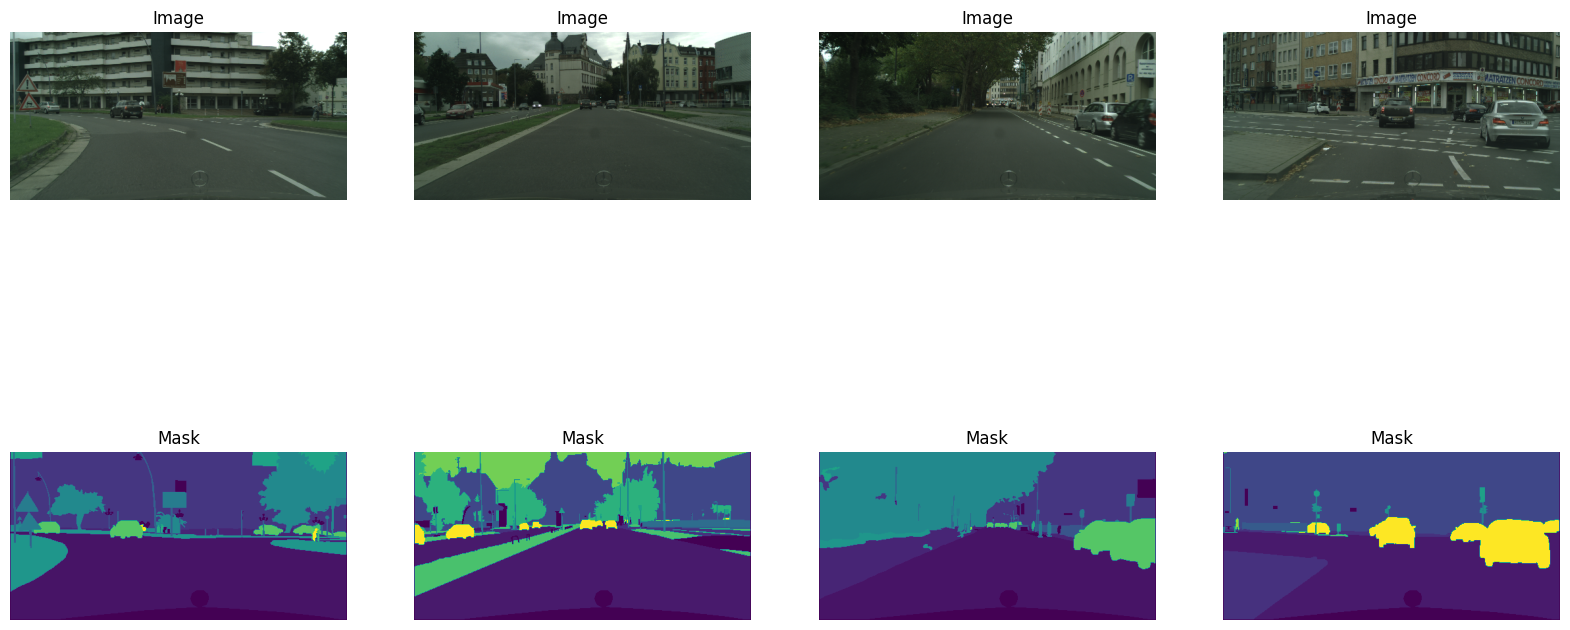

In [ ]:
def plot_images_masks(images, masks, n=4):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title('Image')

        plt.subplot(2, n, n+i+1)
        plt.imshow(masks[i])
        plt.axis('off')
        plt.title('Mask')

    plt.show()

for images, masks in train_dataset.take(1):
    plot_images_masks(images.numpy(), masks.numpy())

In [ ]:
def DeeplabV3Plus(input_shape=(256, 512, 3), num_classes=19):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    image_features = base_model.get_layer('conv4_block6_2_relu').output

    # Atrous Spatial Pyramid Pooling
    b0 = Conv2D(256, (1, 1), padding='same')(image_features)
    b0 = BatchNormalization()(b0)
    b0 = Activation('relu')(b0)

    b1 = Conv2D(256, (3, 3), padding='same', dilation_rate=6)(image_features)
    b1 = BatchNormalization()(b1)
    b1 = Activation('relu')(b1)

    b2 = Conv2D(256, (3, 3), padding='same', dilation_rate=12)(image_features)
    b2 = BatchNormalization()(b2)
    b2 = Activation('relu')(b2)

    b3 = Conv2D(256, (3, 3), padding='same', dilation_rate=18)(image_features)
    b3 = BatchNormalization()(b3)
    b3 = Activation('relu')(b3)

    x = Concatenate()([b0, b1, b2, b3])

    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = UpSampling2D((4, 4), interpolation='bilinear')(x)
    x = Concatenate()([x, base_model.get_layer('conv2_block3_out').output])

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D((4, 4), interpolation='bilinear')(x)
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    x = Activation('softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [ ]:
# def DeeplabV3PlusEfficientNet(input_shape=(256, 512, 3), num_classes=19):
#     base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

#     # Extract features from the base model
#     image_features = base_model.get_layer('top_activation').output

#     # Atrous Spatial Pyramid Pooling
#     b0 = Conv2D(256, (1, 1), padding='same')(image_features)
#     b0 = BatchNormalization()(b0)
#     b0 = Activation('relu')(b0)

#     b1 = Conv2D(256, (3, 3), padding='same', dilation_rate=6)(image_features)
#     b1 = BatchNormalization()(b1)
#     b1 = Activation('relu')(b1)

#     b2 = Conv2D(256, (3, 3), padding='same', dilation_rate=12)(image_features)
#     b2 = BatchNormalization()(b2)
#     b2 = Activation('relu')(b2)

#     b3 = Conv2D(256, (3, 3), padding='same', dilation_rate=18)(image_features)
#     b3 = BatchNormalization()(b3)
#     b3 = Activation('relu')(b3)

#     x = Concatenate()([b0, b1, b2, b3])
#     print("ASPP Concatenate shape:", K.int_shape(x))

#     x = Conv2D(256, (1, 1), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = UpSampling2D((8, 8), interpolation='bilinear')(x)
#     print("Upsampled ASPP shape:", K.int_shape(x))

#     # Low-Level Features from the Backbone
#     low_level_features = base_model.get_layer('block2a_expand_activation').output
#     low_level_features = Conv2D(48, (1, 1), padding='same')(low_level_features)
#     low_level_features = BatchNormalization()(low_level_features)
#     low_level_features = Activation('relu')(low_level_features)
#     print("Low-Level Features shape before upsample:", K.int_shape(low_level_features))

#     # Upsample low-level features to match ASPP output
#     low_level_features = UpSampling2D((2, 2), interpolation='bilinear')(low_level_features)
#     print("Low-Level Features shape after upsample:", K.int_shape(low_level_features))

#     # Ensure the sizes match before concatenation
#     x = Concatenate()([x, low_level_features])
#     print("Concatenate shape:", K.int_shape(x))

#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = UpSampling2D((2, 2), interpolation='bilinear')(x)
#     x = Conv2D(num_classes, (1, 1), padding='same')(x)
#     x = Activation('softmax')(x)

#     model = Model(inputs=base_model.input, outputs=x)
#     return model

In [ ]:
model = DeeplabV3Plus(input_shape=(256, 512, 3), num_classes=n_classes)

# weights_path = '/content/drive/MyDrive/segprooject.h5'

# # Load the saved weights
# model.load_weights(weights_path)

ASPP Concatenate shape: (None, 8, 16, 1024)
Upsampled ASPP shape: (None, 64, 128, 256)
Low-Level Features shape before upsample: (None, 128, 256, 48)
Low-Level Features shape after upsample: (None, 256, 512, 48)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 64, 128, 256), (None, 256, 512, 48)]

In [ ]:
# Create and compile the model

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    smooth = 1.0  # Smoothing factor to avoid division by zero

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Use dice loss in model compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# , tf.keras.metrics.MeanIoU(num_classes=n_classes)

In [ ]:
# from tensorflow.keras.callbacks import Callback
# class MeanIoUCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         mean_iou = logs.get('val_mean_io_u')
#         if mean_iou is not None:
#             print(f" — val_mean_io_u: {mean_iou:.4f}")

In [ ]:
checkpoint = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=callbacks)

Epoch 1/10
372/372 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.8131
Epoch 1: val_loss improved from inf to 1.98707, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


372/372 [==============================] - 445s 1s/step - loss: 0.6482 - accuracy: 0.8131 - val_loss: 1.9871 - val_accuracy: 0.4405 - lr: 1.0000e-04
Epoch 2/10
372/372 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8672
Epoch 2: val_loss improved from 1.98707 to 0.98393, saving model to best_model.h5
372/372 [==============================] - 373s 1s/step - loss: 0.4192 - accuracy: 0.8672 - val_loss: 0.9839 - val_accuracy: 0.6901 - lr: 1.0000e-04
Epoch 3/10
372/372 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8916
Epoch 3: val_loss improved from 0.98393 to 0.48767, saving model to best_model.h5
372/372 [==============================] - 371s 997ms/step - loss: 0.3319 - accuracy: 0.8916 - val_loss: 0.4877 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 4/10
372/372 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.9086
Epoch 4: val_loss improved from 0.48767 to 0.44110, saving model to best_model.h5
372/372 [=======

In [ ]:
from google.colab import files
files.download('best_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

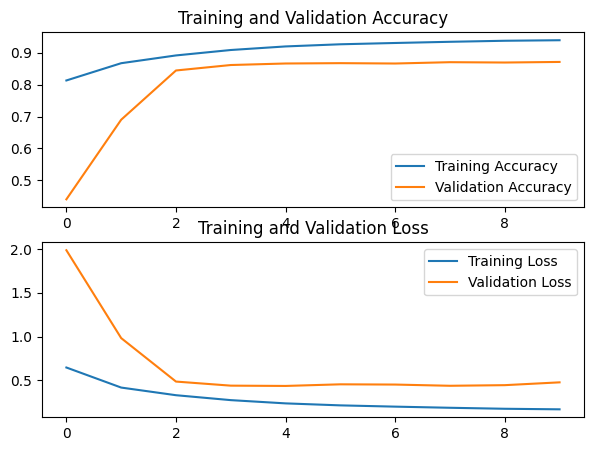

In [ ]:

def plot_training_history(history, save_path=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = history.epoch

    plt.figure(figsize=(7, 5))

    # Plot training and validation accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')

    # Save figure if save_path is provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f'Saving figure to: {save_path}')

    plt.show()

# Define the save path for the figure
# GDRIVE_PATH = '/content/drive/MyDrive/'  # Adjust this path based on your Google Drive structure
# PATH_FIGURE = "Course Indonesia AI - CV/Pertemuan 8 - Final Project/Figure/"
# dir_name = os.path.join(GDRIVE_PATH, PATH_FIGURE)
# save_path = os.path.join(dir_name, "Training_and_Validation.png")

# # Plot the training history
plot_training_history(history)

In [ ]:
def create_cityscapes_colormap():
    colormap = np.zeros((19, 3), dtype=int)
    colormap[0] = [128, 64, 128]   # road
    colormap[1] = [244, 35, 232]   # sidewalk
    colormap[2] = [70, 70, 70]     # building
    colormap[3] = [102, 102, 156]  # wall
    colormap[4] = [190, 153, 153]  # fence
    colormap[5] = [153, 153, 153]  # pole
    colormap[6] = [250, 170, 30]   # traffic light
    colormap[7] = [220, 220, 0]    # traffic sign
    colormap[8] = [107, 142, 35]   # vegetation
    colormap[9] = [152, 251, 152]  # terrain
    colormap[10] = [0, 130, 180]   # sky
    colormap[11] = [220, 20, 60]   # person
    colormap[12] = [255, 0, 0]     # rider
    colormap[13] = [0, 0, 142]     # car
    colormap[14] = [0, 0, 70]      # truck
    colormap[15] = [0, 60, 100]    # bus
    colormap[16] = [0, 80, 100]    # train
    colormap[17] = [0, 0, 230]     # motorcycle
    colormap[18] = [119, 11, 32]   # bicycle
    return colormap

colormap = create_cityscapes_colormap()

In [ ]:
def decode_segmentation_mask(mask, colormap):
    """Convert a grayscale mask to an RGB color mask."""
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

1/1 [==============================] - 2s 2s/step


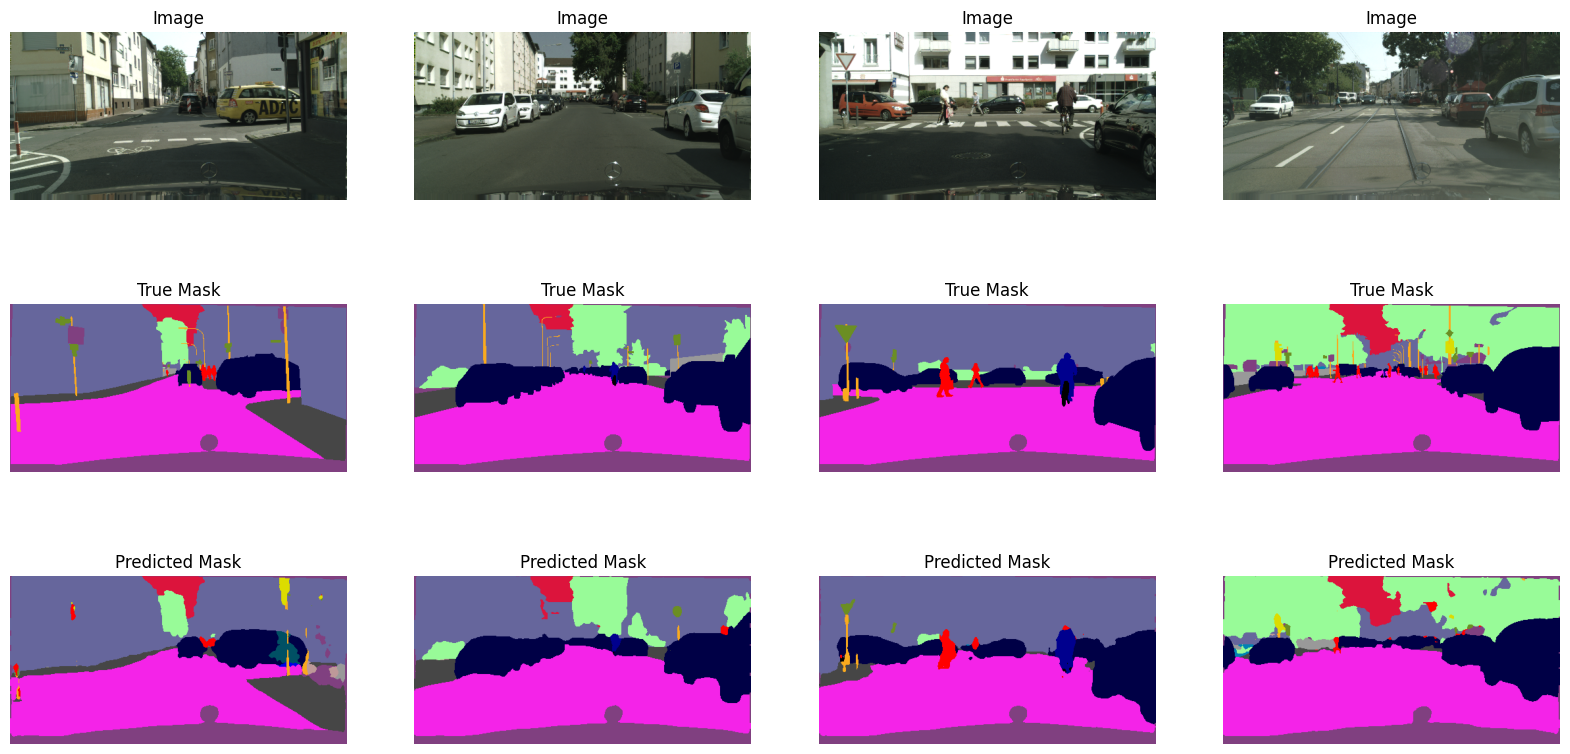

In [ ]:

def plot_predictions(model, dataset, colormap, num_images=4):
    dataset_iter = iter(dataset)
    images, masks = next(dataset_iter)
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title('Image')

        # Plot true mask in color
        true_mask = np.squeeze(masks[i].numpy())
        true_mask_rgb = decode_segmentation_mask(true_mask, colormap)
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(true_mask_rgb)
        plt.axis('off')
        plt.title('True Mask')

        # Plot predicted mask in color
        pred_mask = np.argmax(predictions[i], axis=-1)
        pred_mask_rgb = decode_segmentation_mask(pred_mask, colormap)
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_mask_rgb)
        plt.axis('off')
        plt.title('Predicted Mask')

    plt.show()

# Plot predictions on validation dataset
plot_predictions(model, val_dataset, colormap)


1/1 [==============================] - 0s 29ms/step


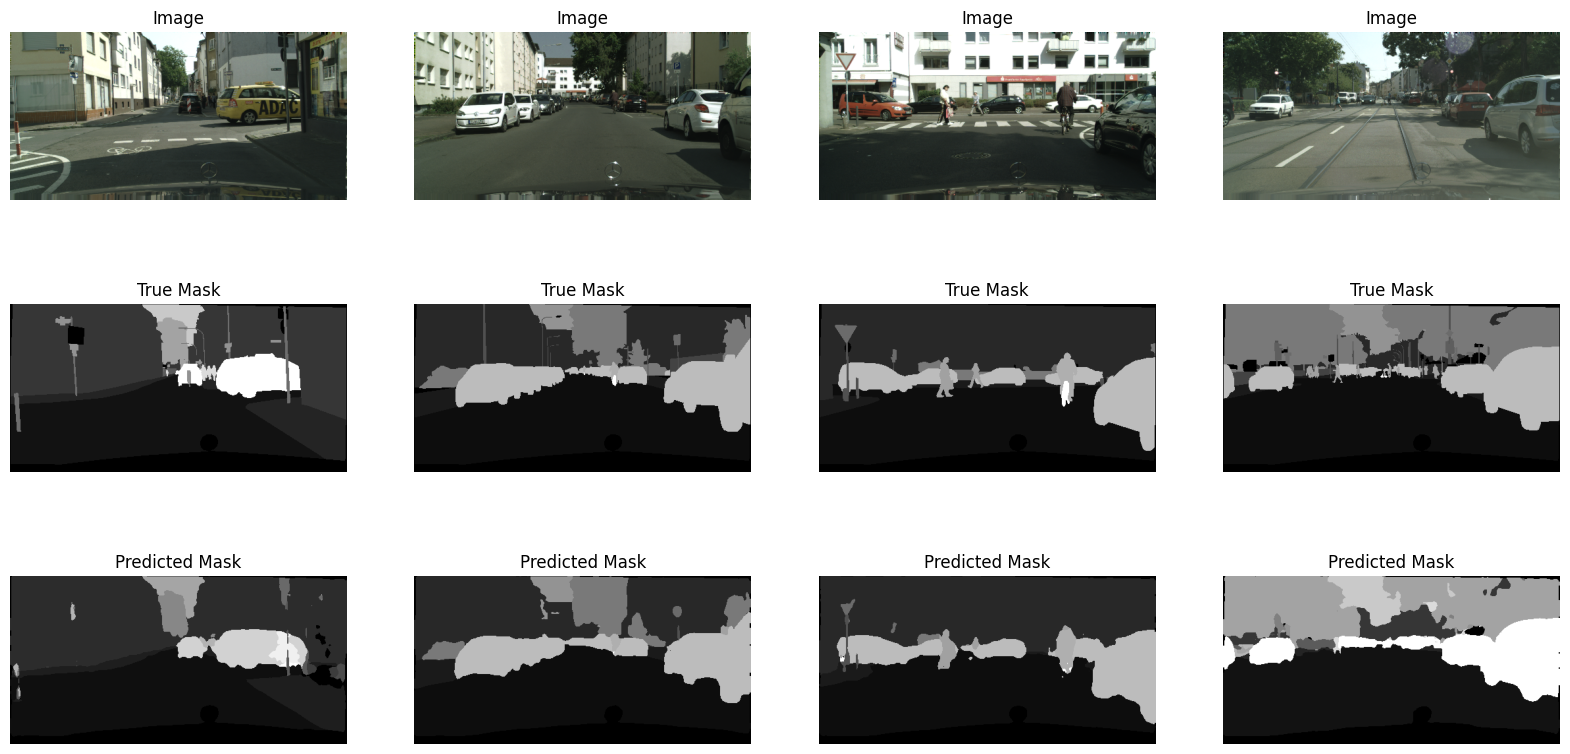

In [ ]:
def plot_predictions(model, dataset, num_images=4):
    images, masks = next(iter(dataset.take(1)))
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title('Image')

        # Plot true mask
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(np.squeeze(masks[i].numpy()), cmap='gray')
        plt.axis('off')
        plt.title('True Mask')

        # Plot predicted mask
        pred_mask = np.argmax(predictions[i], axis=-1)
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')
        plt.title('Predicted Mask')

    plt.show()

# Evaluate the model on the test dataset
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

# Plot predictions on test dataset
plot_predictions(model, val_dataset)